# **Imports**

In [69]:
!pip install -q keras-core --upgrade
!pip install -q keras-nlp --upgrade
!pip install -q tensorflow-text

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [70]:
!pip install -q contractions

In [71]:
import contractions
from textblob import TextBlob

In [72]:
# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [73]:
!pip install -q --upgrade keras

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.5.0 which is incompatible.


You might have to restart the kernel here.

In [74]:
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split, KFold

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, FileLink

from tqdm import tqdm
tqdm.pandas()

In [75]:
import tensorflow as tf
import keras_core as keras
import keras_nlp

from tensorflow.keras.callbacks import EarlyStopping


# **Load the data**

In [76]:
# Directories
data_dir = '/kaggle/input/nlp-getting-started/'

In [77]:
train_df = pd.read_csv(data_dir + "train.csv")
test_df = pd.read_csv(data_dir + "test.csv")

print('Training Set Size:', format(len(train_df)))
print('Test Set Size:', format(len(test_df)))

Training Set Size: 7613
Test Set Size: 3263


In [78]:
print(len(train_df))
print(len(train_df[train_df['keyword'].notna()]))

7613
7552


In [79]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# **Clean the data**

In [80]:
# Check for '%20' in the 'keyword' column
print("keyword column")
display(train_df[train_df['keyword'].str.contains('%20', na = False)].head())

# Check for '%20' in the 'text' column
print("text column")
display(train_df[train_df['text'].str.contains('%20', na = False)].head())

# Replace '%20' with ' ' in the keyword column
train_df['keyword'] = train_df['keyword'].str.replace(r'%20', ' ', regex = True)

keyword column


,id,keyword,location,text,target
136,196,airplane%20accident,"19.600858, -99.047821",Experts in France begin examining airplane deb...,1
137,197,airplane%20accident,Pennsylvania,Strict liability in the context of an airplane...,1
138,198,airplane%20accident,"Salt Lake City, Utah",@crobscarla your lifetime odds of dying from a...,0
139,199,airplane%20accident,"Palo Alto, CA",Experts in France begin examining airplane deb...,1
140,201,airplane%20accident,NaN,@AlexAllTimeLow awwww they're on an airplane a...,1


text column


,id,keyword,location,text,target


In [81]:
# Add the keyword (if there is one) to the beginning of the text
train_df['text'] = train_df['keyword'].fillna('') + ' ' + train_df['text']

# Verify the results
train_df[train_df['keyword'].notna()].head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,ablaze @bbcmtd Wholesale Markets ablaze http:/...,1
32,49,ablaze,Est. September 2012 - Bristol,ablaze We always try to bring the heavy. #meta...,0
33,50,ablaze,AFRICA,ablaze #AFRICANBAZE: Breaking news:Nigeria fla...,1
34,52,ablaze,"Philadelphia, PA",ablaze Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",ablaze On plus side LOOK AT THE SKY LAST NIGHT...,0


In [82]:
# Remove URLs
# train_df['text'] = train_df['text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)

In [83]:
# Remove mentions
# train_df['text'] = train_df['text'].str.replace(r'@\w+', '', regex=True)

In [84]:
# Remove hashtags
# train_df['text'] = train_df['text'].str.replace(r'#\w+', '', regex=True)

In [85]:
# # Expand contractions
# train_df['text'] = train_df['text'].apply(lambda x: contractions.fix(x))

In [86]:
# # Handle misspellings
# train_df['text'] = train_df['text'].progress_apply(lambda x: str(TextBlob(x).correct()))

In [87]:
# Simple cleaning
# Removes all characters that are not upper- or lower-case English letters, or whitespaces.
# Note, it till turn #BigStory into bigstory, i.e. it will not remove the phrase following the #.
train_df['text'] = train_df['text'].str.replace(r'[^a-zA-Z\s]', '', regex = True).str.lower()

In [88]:
# Save the cleaned data frame
display(train_df.head())
train_df.to_csv('/kaggle/working/train_df.csv', index = False)

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake m...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are b...,1
3,6,NaN,NaN,people receive wildfires evacuation orders i...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as ...,1


In [89]:
# Reload the cleaned data fram
train_df = pd.read_csv("/kaggle/working/train_df.csv")
display(train_df.head())

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake m...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are b...,1
3,6,NaN,NaN,people receive wildfires evacuation orders i...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as ...,1


# **Misclassified samples**

In [90]:
print(len(train_df))
mislabeled_df = train_df.groupby(['text']).nunique().sort_values(by='target', ascending=False)
mislabeled_tweets = mislabeled_df[mislabeled_df['target'] > 1]['target'].index.tolist()

train_df = train_df[~train_df['text'].isin(mislabeled_tweets)]
print(len(train_df))

7613
7549


# **Exploratory Data Analysis**

In [116]:
# Check if there is any clear difference in tweet-length distribution
# between the two classes
train_df['length'] = train_df['text'].apply(lambda x: len(x))

print("Tweet-length stats: class 0")
print(train_df[train_df['target'] == 0]['length'].describe())
print()


print("Tweet-length stats: class 1")
print(train_df[train_df['target'] == 1]['length'].describe())



Tweet-length stats: class 0
count    4306.000000
mean       96.418950
std        33.774281
min         8.000000
25%        71.000000
50%       100.500000
75%       126.000000
max       155.000000
Name: length, dtype: float64

Tweet-length stats: class 1
count    3243.000000
mean      107.517422
std        27.831385
min        15.000000
25%        88.000000
50%       112.000000
75%       131.000000
max       158.000000
Name: length, dtype: float64


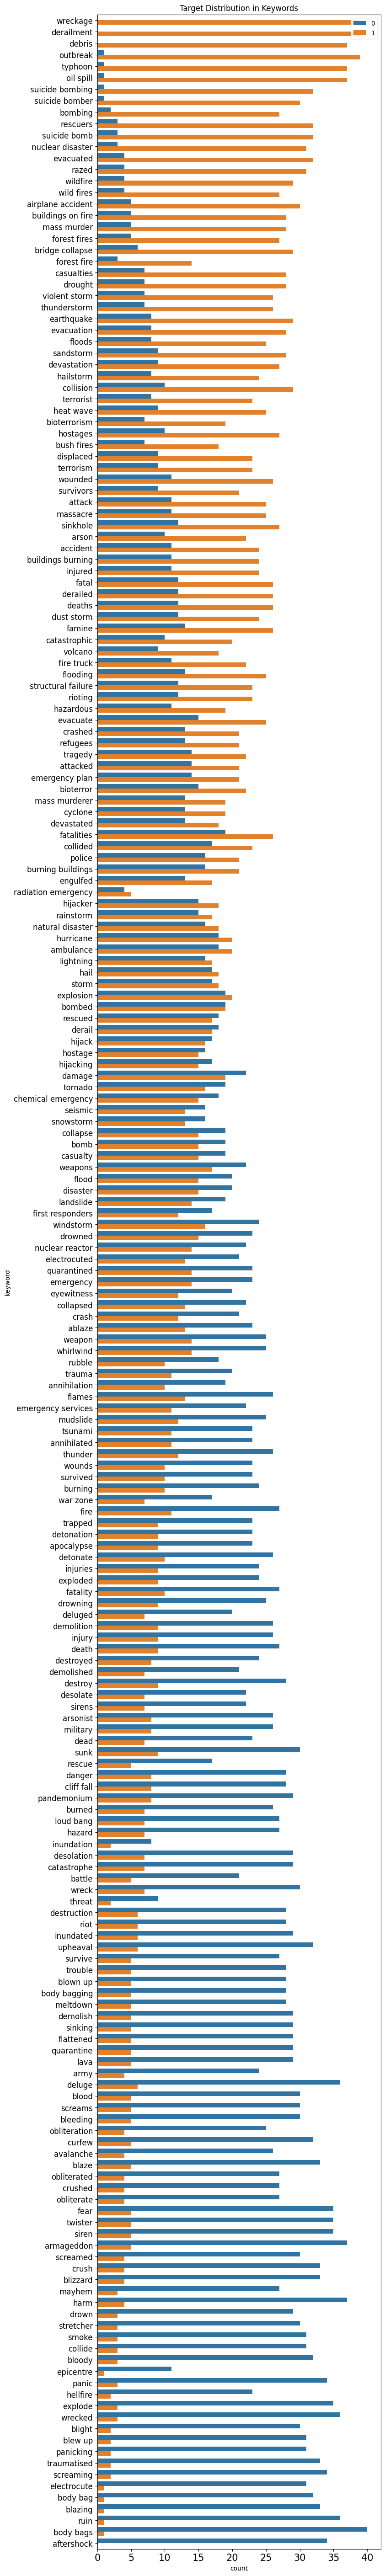

In [94]:
train_df['target_mean'] = train_df.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=train_df.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train_df.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train_df.drop(columns=['target_mean'], inplace=True)

# **Take a sample of the data**

To speed up early hyper-parameter tuning, we'll start by training the model on just a portion of the training set, perhaps 10%. As we continue fine-tuning the hyper-parameters, we'll increase this portion to 25%, 50%, and finally to 100%.

In [95]:
# Take just a portion of the data, for early testing
sample_fraction = 1 # Start with 0.1 and increase to 0.25, 0.5, and finally 1
train_df_to_use = train_df.sample(frac = sample_fraction, random_state = 42)

# Verify the sample
print(f'Full training set: {len(train_df)}')
print(f'Sampled training set: {len(train_df_to_use)}')

Full training set: 7549
Sampled training set: 7549


# **Split the data**

In [96]:
# TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2

# The "text" col holds the tweets; 
# the "target" col has 0 (not disaster-related) or 1 (disaster-related)
X = train_df_to_use["text"]
y = train_df_to_use["target"]

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = VAL_SPLIT, random_state = 42)

# Extract the tweets from the test data
X_test = test_df["text"]

# **Model**

In [97]:
BATCH_SIZE = 16
# STEPS_PER_EPOCH = len(X_train) // BATCH_SIZE

EPOCHS = 20
AUTO = tf.data.experimental.AUTOTUNE

In [98]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Get the max-length of the tweets
max_length = train_df['text'].apply(lambda x: len(x)).max()
print("The longest tweet is", max_length, "characters long.")

# Preprocessor
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length = max_length,
                                                                   name = "preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes = 2)

classifier.summary()

Attaching 'model.safetensors' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'model.safetensors.index.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'preprocessor.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook.

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [99]:
# Compile
classifier.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), #'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-6),
    metrics= ["accuracy"]
)


# **Model training**

In [100]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights = True)

# Fit
history = classifier.fit(x = X_train,
                         y = y_train,
                         batch_size = BATCH_SIZE,
                         epochs = EPOCHS,
                         validation_data = (X_val, y_val),
                         callbacks = [early_stopping]
                        )

Epoch 1/20
  1/378 ━━━━━━━━━━━━━━━━━━━━ 5:53:12 56s/step - accuracy: 0.5625 - loss: 0.6916

I0000 00:00:1724077767.661168    1281 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724077767.705725    1281 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.6772 - loss: 0.6139

W0000 00:00:1724077853.776744    1280 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724077857.278862    1280 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724077862.272888    1281 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


378/378 ━━━━━━━━━━━━━━━━━━━━ 151s 252ms/step - accuracy: 0.6774 - loss: 0.6136 - val_accuracy: 0.8245 - val_loss: 0.4116
Epoch 2/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 50s 132ms/step - accuracy: 0.8213 - loss: 0.4255 - val_accuracy: 0.8265 - val_loss: 0.3986
Epoch 3/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 50s 133ms/step - accuracy: 0.8354 - loss: 0.3971 - val_accuracy: 0.8305 - val_loss: 0.3936
Epoch 4/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 50s 132ms/step - accuracy: 0.8523 - loss: 0.3658 - val_accuracy: 0.8199 - val_loss: 0.4106
Epoch 5/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 50s 132ms/step - accuracy: 0.8761 - loss: 0.3386 - val_accuracy: 0.8179 - val_loss: 0.4199
Epoch 6/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 50s 132ms/step - accuracy: 0.8769 - loss: 0.3260 - val_accuracy: 0.8245 - val_loss: 0.4235


# **Evaluation**

In [101]:
# Evaluate the model on the validation set
score, accuracy = classifier.evaluate(X_val, y_val, verbose = 2)
print(f"Validation Accuracy: {accuracy}")

W0000 00:00:1724078116.462615    1281 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


48/48 - 5s - 108ms/step - accuracy: 0.8305 - loss: 0.3936
Validation Accuracy: 0.8304635882377625


# **Prediction and Confusion Matrix**

In [102]:
# Function that outputs a confusion matrix
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis = 1),
        display_labels=["Not Disaster", "Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

 3/48 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step

W0000 00:00:1724078122.745012    1280 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step


W0000 00:00:1724078127.850850    1281 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


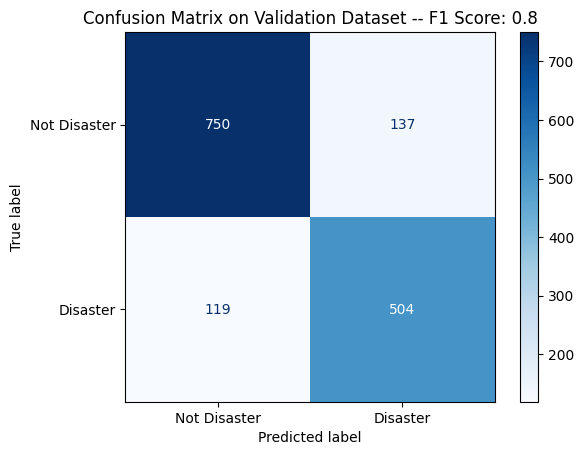

In [103]:
# Predict on the validation data
y_val_pred = classifier.predict(X_val)

# Output the confusion matrix for the validation data
displayConfusionMatrix(y_val, y_val_pred, "Validation")

# **Predict on test data and generate submission file**

In [104]:
# Predict on the test data
test_pred = np.argmax(classifier.predict(X_test), axis = 1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step


W0000 00:00:1724078137.367757    1280 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [105]:
# Get the test_ids from the test data
test_ids = test_df["id"]

# Create a DataFrame
submission = pd.DataFrame({
    'id': test_ids,
    'target': test_pred
})

# Take a look at the results
print(submission.head())

# Generate a unique filename with a timestamp
timestamp = datetime.now().strftime('%Y-%m-%d_%H%M')
filename = f'dtsa-5511-m4-submission_{timestamp}.csv'

# Save the DataFrame to a CSV file
submission.to_csv(filename, index = False)

# Generate a download link.
FileLink(rf'{filename}')

   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


/kaggle/working/dtsa-5511-m4-submission_2024-08-19_1435.csv